Check GPU status

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


Install transformers library to load the model florence-2 and data preprocessor for the model and the dependencies of model loader. Install supervision, which provides annotation helpers

In [ ]:
!pip install -q transformers flash_attn timm
!pip install -q git+https://github.com/roboflow/supervision.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Required imports

In [ ]:
import torch
import supervision as sv
from transformers import (
    AutoModelForCausalLM,
    AutoProcessor,
)
from PIL import Image

Load the model and preprocessor through checkpointing and check for the GPU availability

In [ ]:
CHECKPOINT = "microsoft/Florence-2-base-ft"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884


Helper function to to keep only person and face bounding boxes and discard others

In [ ]:
def get_refined_response(response):
  count = 0
  index = []
  for label in response['<OD>']['labels']:
    if label=='human face' or label=='face' or label=='person':
      index.append(count)
    count = count + 1
  bboxes = [response['<OD>']['bboxes'][i] for i in index]
  labels = [response['<OD>']['labels'][i] for i in index]
  print(bboxes,labels)
  refined_response = {
    "<OD>": {
        "bboxes": bboxes,
        "labels": labels
    }
  }
  return refined_response

Helper function to perform person and face detection

In [ ]:
def detect_person_face(image):
  task = "<OD>"
  text = "<OD>"

  inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
  generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      num_beams=3
  )
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
  response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
  refined_response = get_refined_response(response)
  detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, refined_response, resolution_wh=image.size)
  bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
  label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)
  image = bounding_box_annotator.annotate(image, detections)
  image = label_annotator.annotate(image, detections)
  image.thumbnail((600,600))
  return image

Helper function to perform gender inference

In [ ]:
def detect_gender(image):
  task = "<CAPTION>"
  text = "<Gender>"

  inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
  generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
  )
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
  response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
  print(response['<CAPTION>'])

Load image to infer

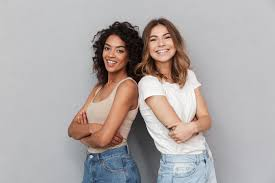

In [ ]:
image_path = 'download.jpeg'
image = Image.open(image_path)
image

Perform person and face detection

[[146.71250915527344, 24.064498901367188, 176.41250610351562, 61.579498291015625], [102.1624984741211, 34.12950134277344, 128.83750915527344, 72.19349670410156], [134.6125030517578, 17.842500686645508, 217.66250610351562, 182.72549438476562], [67.51250457763672, 21.136499404907227, 143.6875, 182.72549438476562]] ['human face', 'human face', 'person', 'person']


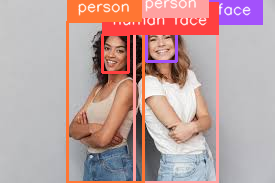

In [ ]:
image = Image.open(image_path)
output_image = detect_person_face(image)
output_image

Perform gender inference

In [ ]:
# Loading the image again
image = Image.open(image_path)
detect_gender(image)

female
